## OSM Street Masks

in this notebook we load the street mmasks from osm into our dataset

In [1]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 5.8 MB/s eta 0:00:00a 0:00:01
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1

In [3]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd

import re
import osmnx as ox
import geopandas as gpd

/Users/jonaserbacher/PycharmProjects/pythonProject8/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Loading the data from omsnx and creating it to get a mask with street information for the model

In [54]:
import os
import numpy as np
from shapely.geometry import Polygon
from pyproj import Transformer
import osmnx as ox

# A function to create the masks which expects the name of the folder as an input
def create_masks(name):
    image_directory = f"./train_test_split/{name}"
    mask_directory = f"./train_test_split/{name}"

    if not os.path.exists(mask_directory):
        os.makedirs(mask_directory)

    # Loop through the folders in the image directory
    for folder in os.listdir(image_directory):
        folder_path = os.path.join(image_directory, folder)
        if os.path.isdir(folder_path):
            mask_folder_path = os.path.join(mask_directory, folder)
            if not os.path.exists(mask_folder_path):
                os.makedirs(mask_folder_path)

            # Loop through the files in the folder
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".png"):
                    # Extract coordinates from the folder name
                    X, Y = map(int, folder.split("_"))
                    X, Y = X * 100, Y * 100

                    # change the coordinate system from EPSG:2056 to EPSG:4326
                    transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")
                    south, west = transformer.transform(X, Y)
                    north, east = transformer.transform(X + 100, Y + 100)

                    try:
                        # gather the geo information
                        geo_information = ox.features_from_bbox(north, south, east, west, tags={'highway': True})
                    except:
                        # if there is no geo information, save an empty mask
                        np.save(os.path.join(mask_folder_path, "street_mask.npy"), np.zeros((1000, 1000)))
                        continue

                    # create an empty raster
                    raster = np.zeros((1000, 1000))

                    # loop through the raster; An increase of 1 in the x direction is 1 metre, an increase of 1 in the y direction is 1 metre
                    # we start in the top left corner and go down and right
                    for x_west in range(1000):
                        for y_north in range(1000):
                            x_west_coordinate = X + x_west/10
                            y_north_coordinate = (Y + 100) - y_north/10
                            small_north, small_west = transformer.transform(x_west_coordinate, y_north_coordinate)
                            small_south, small_east = transformer.transform(x_west_coordinate + 1, y_north_coordinate - 1)
                            # create a polygon for each square metre
                            square_metre = Polygon([(small_west, small_north), (small_east, small_north),
                                                    (small_east, small_south), (small_west, small_south)])
                            # compare it to the geoinformation and set the value to 1 if it intersects
                            if geo_information.intersects(square_metre).any():
                                raster[y_north, x_west] = 1
                    np.save(os.path.join(mask_folder_path, "street_mask.npy"), raster)


create_masks("validation")

In [60]:

create_masks("test")

In [65]:
create_masks("train")

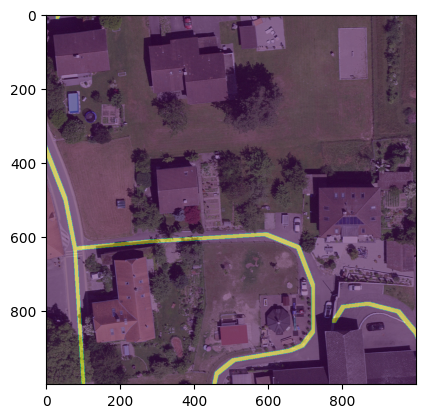

In [59]:
import matplotlib.pyplot as plt
from PIL import Image

# Plotting the image and the mask to see if it worked
image = np.array(Image.open("./train_test_split/validation/25972_12095/img.png"))
mask = np.load("./train_test_split/validation/25972_12095/street_mask.npy")
plt.imshow(image)
plt.imshow(mask,alpha=0.5)
plt.plot();

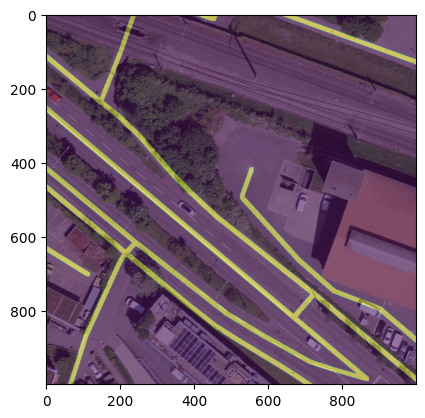

In [67]:
import matplotlib.pyplot as plt

image = np.array(Image.open("./train_test_split/train/26799_12530/img.png"))
mask = np.load("./train_test_split/train/26799_12530/street_mask.npy")
plt.imshow(image)
plt.imshow(mask,alpha=0.5)
plt.plot();